Loaded data. Intrinsic Dimension d = 10
Figure saved to: ../results/figures/fig4_saturation.pdf


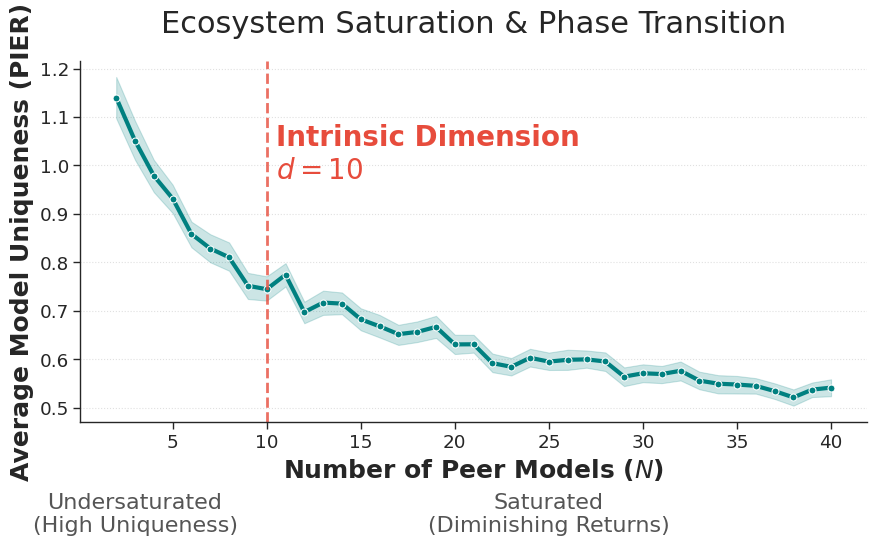

In [1]:
# %% [markdown]
# # Figure 4: Ecosystem Saturation & Phase Transition
# 
# This notebook visualizes the fundamental limit of an AI ecosystem's capacity.
# 
# **Theoretical Prediction:**
# As the number of peer models ($N$) increases, the available "uniqueness space" shrinks.
# When $N$ approaches the intrinsic task dimension ($d$), we expect a sharp **phase transition** where the average uniqueness (PIER) collapses toward zero.
# 
# **Key Insight for NMI:**
# This demonstrates that simply adding more models to an ecosystem yields diminishing returns. There is a finite "Capacity" for uniqueness.

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# %% [markdown]
# ## 1. Load Experimental Data

# %%
DATA_PATH = "../results/tables/exp2_saturation.csv"
FIG_PATH = "../results/figures"

os.makedirs(FIG_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Please run 'experiments/exp2_saturation.py' first.")

df = pd.read_csv(DATA_PATH)

# Extract the dimension used in the experiment for plotting the vertical line
dimension = df['dimension'].iloc[0]
print(f"Loaded data. Intrinsic Dimension d = {dimension}")
df.head()

# %% [markdown]
# ## 2. Configure Nature-Style Aesthetics
# 
# We use a clean, scientific style.
# * **Color:** A gradient or distinct color (e.g., Purple or Teal) to distinguish from previous figures. Let's use **Teal** to represent "Capacity/Volume".

# %%
sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

# Nature-style colors
COLOR_MAIN = "#008080" # Teal
COLOR_GUIDE = "#E74C3C" # Red for the limit line

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# %% [markdown]
# ## 3. Generate the Saturation Curve
# 
# We plot **Average PIER Score (Y-axis)** vs. **Number of Peers (X-axis)**.
# The shaded region is the 95% confidence interval.

# %%
plt.figure(figsize=(9, 6))

# Main Curve
ax = sns.lineplot(
    data=df,
    x="n_peers",
    y="pier_score",
    color=COLOR_MAIN,
    linewidth=3,
    marker="o",
    markersize=5,
    err_style="band", # Shaded confidence interval
    errorbar=('ci', 95) # 95% confidence interval
)

# --- Aesthetic Customization ---

# 1. Labels
ax.set_xlabel("Number of Peer Models ($N$)", fontsize=18, fontweight='bold')
ax.set_ylabel("Average Model Uniqueness (PIER)", fontsize=18, fontweight='bold')
ax.set_title("Ecosystem Saturation & Phase Transition", fontsize=22, pad=20)

# 2. Critical Theoretical Boundary (The "Capacity")
# Draw a vertical line at N = d (The theoretical saturation point)
plt.axvline(x=dimension, color=COLOR_GUIDE, linestyle='--', linewidth=2, alpha=0.8)

# 3. Annotations
# Phase 1: Undersaturated
ax.text(dimension * 0.3, ax.get_ylim()[1] * 0.2, 
        "Undersaturated\n(High Uniqueness)", 
        fontsize=16, color='#555555', ha='center')

# Phase 2: Saturated
ax.text(dimension * 2.5, ax.get_ylim()[1] * 0.2, 
        "Saturated\n(Diminishing Returns)", 
        fontsize=16, color='#555555', ha='center')

# Label the Limit Line
ax.text(dimension + 0.5, ax.get_ylim()[1] * 0.8, 
        f"Intrinsic Dimension\n$d = {dimension}$", 
        color=COLOR_GUIDE, fontsize=20, fontweight='bold')

# 4. Spines
sns.despine()

# 5. Grid (Optional, for readability)
ax.grid(True, which='major', axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()

# %% [markdown]
# ## 4. Save Figure
# 
# This figure validates the **Ecosystem Saturation Theorem**.

# %%
save_path = os.path.join(FIG_PATH, "fig4_saturation.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")

# Show plot
plt.show()

Figure saved to: ../results/figures/saturation_dense_nature.pdf


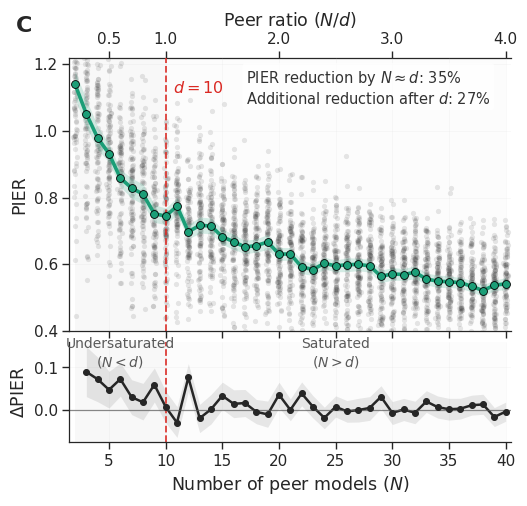

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# -------------------------
# Load
# -------------------------
DATA_PATH = "../results/tables/exp2_saturation.csv"
FIG_PATH  = "../results/figures"
os.makedirs(FIG_PATH, exist_ok=True)

df = pd.read_csv(DATA_PATH)

req = {"n_peers", "pier_score"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

dimension = None
if "dimension" in df.columns and df["dimension"].notna().any():
    dimension = float(df["dimension"].dropna().iloc[0])

# -------------------------
# Style (Nature-ish, consistent with your Fig.2 panel)
# -------------------------
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12.5,
    "axes.labelsize": 12.5,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 0.9,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

COLOR_MAIN  = "#1B9E77"   # muted teal
COLOR_CRIT  = "#DA2923"   # muted red
COLOR_RAW   = "0.2"       # gray

# -------------------------
# Bootstrap helpers
# -------------------------
def bootstrap_ci_mean(y, n_boot=2000, ci=95, seed=123):
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return np.nan, np.nan, np.nan
    mean = float(np.mean(y))
    if y.size == 1:
        return mean, mean, mean
    rng = np.random.default_rng(seed)
    boots = rng.choice(y, size=(n_boot, y.size), replace=True).mean(axis=1)
    alpha = (100 - ci) / 2.0
    lo = float(np.percentile(boots, alpha))
    hi = float(np.percentile(boots, 100 - alpha))
    return mean, lo, hi

def bootstrap_ci_diff(y1, y2, n_boot=2000, ci=95, seed=321):
    """CI for mean(y1) - mean(y2) via independent bootstrap."""
    y1 = np.asarray(y1, dtype=float)
    y2 = np.asarray(y2, dtype=float)
    y1 = y1[np.isfinite(y1)]
    y2 = y2[np.isfinite(y2)]
    if y1.size == 0 or y2.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = []
    for _ in range(n_boot):
        m1 = rng.choice(y1, size=y1.size, replace=True).mean()
        m2 = rng.choice(y2, size=y2.size, replace=True).mean()
        boots.append(m1 - m2)
    boots = np.asarray(boots, dtype=float)
    mean = float(np.mean(boots))
    alpha = (100 - ci) / 2.0
    lo = float(np.percentile(boots, alpha))
    hi = float(np.percentile(boots, 100 - alpha))
    return mean, lo, hi

# -------------------------
# Summaries
# -------------------------
rows = []
for N, sub in df.groupby("n_peers", dropna=False):
    y = sub["pier_score"].to_numpy()
    mean, lo, hi = bootstrap_ci_mean(y, n_boot=2000, ci=95, seed=123 + int(float(N)))
    rows.append({"n_peers": float(N), "mean": mean, "lo": lo, "hi": hi, "n": len(sub)})
summ = pd.DataFrame(rows).sort_values("n_peers")

# marginal drop: U(N-1) - U(N)
Ns = summ["n_peers"].to_numpy()
delta_rows = []
for i in range(1, len(Ns)):
    N_prev, N_cur = float(Ns[i-1]), float(Ns[i])
    y_prev = df.loc[df["n_peers"] == N_prev, "pier_score"].to_numpy()
    y_cur  = df.loc[df["n_peers"] == N_cur,  "pier_score"].to_numpy()
    d_mean, d_lo, d_hi = bootstrap_ci_diff(y_prev, y_cur, n_boot=2000, ci=95, seed=777 + i)
    delta_rows.append({"n_peers": N_cur, "mean": d_mean, "lo": d_lo, "hi": d_hi})
delta = pd.DataFrame(delta_rows).sort_values("n_peers")

# -------------------------
# Figure layout: main + marginal gains
# -------------------------
fig = plt.figure(figsize=(5.2, 4.8))
gs = GridSpec(2, 1, height_ratios=[3.15, 1.15], hspace=0.06)
ax  = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax)

for a in (ax, ax2):
    a.grid(True, which="major", linewidth=0.6, alpha=0.12)
    a.set_axisbelow(True)

# ----- background regime shading (subtle) -----
xmin, xmax = float(summ["n_peers"].min()), float(summ["n_peers"].max())
if dimension is not None and xmin < dimension < xmax:
    ax.axvspan(xmin, dimension, color="0.5", alpha=0.05, lw=0)
    ax.axvspan(dimension, xmax, color="0.5", alpha=0.02, lw=0)
    ax2.axvspan(xmin, dimension, color="0.5", alpha=0.05, lw=0)
    ax2.axvspan(dimension, xmax, color="0.5", alpha=0.02, lw=0)

# ----- raw points (transparent, jittered) -----
rng = np.random.default_rng(0)
x_raw = df["n_peers"].astype(float).to_numpy()
y_raw = df["pier_score"].astype(float).to_numpy()

# small jitter in x to reveal multiplicity
xj = x_raw + rng.normal(0.0, 0.08, size=x_raw.shape)
ax.scatter(xj, y_raw, s=14, color=COLOR_RAW, alpha=0.12, linewidths=0, zorder=0)

# ----- main curve + CI -----
x = summ["n_peers"].to_numpy()
y = summ["mean"].to_numpy()
lo = summ["lo"].to_numpy()
hi = summ["hi"].to_numpy()

ax.fill_between(x, lo, hi, color=COLOR_MAIN, alpha=0.18, linewidth=0)
ax.plot(x, y, color=COLOR_MAIN, linewidth=2.6, zorder=3)
ax.scatter(x, y, s=32, color=COLOR_MAIN, edgecolor="black", linewidth=0.6, zorder=4)

# critical line N=d
if dimension is not None:
    ax.axvline(dimension, color=COLOR_CRIT, linestyle="--", linewidth=1.3, alpha=0.9)
    ax2.axvline(dimension, color=COLOR_CRIT, linestyle="--", linewidth=1.3, alpha=0.9)
    ax.text(
        0.35, 0.92, f"$d={int(dimension)}$",
        transform=ax.transAxes, ha="right", va="top",
        fontsize=11.5, color=COLOR_CRIT
    )

# labels
ax.set_ylabel("PIER")
ax2.set_ylabel(r"$\Delta$PIER")
ax2.set_xlabel("Number of peer models ($N$)")

# tight y-lims (avoid empty headroom)
ax.set_xlim(xmin - 0.5, xmax + 0.5)
ax.set_ylim(bottom=0.4, top=float(np.nanmax(hi)) + 0.04)

# ----- marginal drop panel -----
if not delta.empty:
    xd = delta["n_peers"].to_numpy()
    yd = delta["mean"].to_numpy()
    lod = delta["lo"].to_numpy()
    hid = delta["hi"].to_numpy()

    ax2.fill_between(xd, lod, hid, color="0.15", alpha=0.10, linewidth=0)
    ax2.plot(xd, yd, color="0.15", linewidth=1.8)
    ax2.scatter(xd, yd, s=18, color="0.15", zorder=3)
ax2.axhline(0.0, color="0.35", linewidth=0.9, alpha=0.7)

# small regime labels under the axis (compact, like the paper)
if dimension is not None and xmin < dimension < xmax:
    ax2.text(
        (xmin + dimension) / 2.0, 1.05,
        "Undersaturated\n($N<d$)",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="top", fontsize=10.0, color="0.35"
    )
    ax2.text(
        (dimension + xmax) / 2.0, 1.05,
        "Saturated\n($N>d$)",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="top", fontsize=10.0, color="0.35"
    )

# secondary x-axis: N/d
if dimension is not None and dimension > 0:
    secax = ax.secondary_xaxis("top", functions=(lambda N: N / dimension, lambda r: r * dimension))
    secax.set_xlabel(r"Peer ratio ($N/d$)")
    # choose a few clean ticks
    r_ticks = np.array([0.5, 1.0, 2.0, 3.0, 4.0])
    r_ticks = r_ticks[(r_ticks * dimension >= xmin) & (r_ticks * dimension <= xmax)]
    if r_ticks.size > 0:
        secax.set_xticks(r_ticks)
        secax.set_xticklabels([f"{t:.1f}" for t in r_ticks])

# quantitative summary box (high information per character)
# use nearest N to d if d is not exactly present
if dimension is not None:
    idx_d = int(np.argmin(np.abs(x - dimension)))
    U1 = float(y[0])
    Ud = float(y[idx_d])
    Umax = float(y[-1])
    drop_to_d = (U1 - Ud) / max(U1, 1e-12)
    drop_after = (Ud - Umax) / max(Ud, 1e-12)
    ax.text(
        0.40, 0.96,
        f"PIER reduction by $N\\approx d$: {100*drop_to_d:.0f}%\nAdditional reduction after $d$: {100*drop_after:.0f}%",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=10.5, color="0.2",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.75),
    )

# remove top panel x tick labels
plt.setp(ax.get_xticklabels(), visible=False)

# final layout
fig.subplots_adjust(left=0.12, right=0.97, bottom=0.1, top=0.90)

# panel label (optional)
ax.text(-0.12, 1.08, "C", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

save_path = os.path.join(FIG_PATH, "saturation_dense_nature.pdf")
fig.savefig(save_path, format="pdf")
print(f"Figure saved to: {save_path}")
plt.show()
